In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
from loguru import logger

In [5]:
datapath = "data/data.csv"

# Load Data


> **Note**: It seems pandas couldn't read a large chunk of data. It's only able to load 6K data points.
I am sure I could have solved this, but the solution is just a crude way to approach the given problem for tagging a description. So, I let it be. (Plus, it was race against time)

### Important

If we're going to train a BERT-based Language Model, we will only use a subset of the data where
the length of the description < 512 (since BERT can only process 512 input tokens at a time).

> **NOTE**:
- This can be solved by treating classification of single data point as chunks where we could break the long text.
- Or, we can use other robust models like [Longformer](https://github.com/allenai/longformer) that can process 
at max 4096 input characters. 

In [24]:
def parse_kws(kw_str, level=2):
    res = kw_str.split(",")
    res = map(lambda kw: [_.strip().lower() for _ in kw.split(">")], res)
    res = map(lambda x: x[level if level<len(x) else len(x)-1], res)
    return list(set(res))

def load_data(path, level=0):
    logger.info(f"Loading data from {path}. [KW Level={level}]")
    df = pd.read_csv(path)
    df["desc"] = df["desc"].apply(str.strip)
    df["labels"] = df["keywords"].apply(lambda x: parse_kws(x, level))
    df["textlen"] = df["desc"].apply(len)
    return df

In [25]:
DATA = load_data(datapath, level=1)

2021-07-28 19:09:25.591 | INFO     | __main__:load_data:8 - Loading data from data/data.csv. [KW Level=1]


In [37]:
# Like I said, we're only able to load 6K data points which can be fixed in future!
DATA.shape

(5999, 4)

In [38]:
DATA.head()

,desc,keywords,labels,textlen
0,USGS 15 minute stream flow data for Kings Cree...,EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURF...,[terrestrial hydrosphere],68
1,"This data set contains the VSMOW-SLAP d17O, d1...",EARTH SCIENCE > Solid Earth > Rocks/Minerals >...,"[cryosphere, solid earth]",425
2,Digital line graph (DLG) data are digital repr...,EARTH SCIENCE > HUMAN DIMENSIONS > BOUNDARIES ...,"[terrestrial hydrosphere, human dimensions]",751
3,The 2000 Pilot Environmental Sustainability In...,EARTH SCIENCE > ATMOSPHERE > AIR QUALITY > EMI...,"[terrestrial hydrosphere, biosphere, human dim...",956
4,The 2001 Environmental Sustainability Index (E...,EARTH SCIENCE > ATMOSPHERE > AIR QUALITY > EMI...,"[terrestrial hydrosphere, biosphere, human dim...",989


# Analysis

In [39]:
from collections import Counter, defaultdict

In [40]:
from loguru import logger

In [41]:
def analyze_labels(df):
    df = df.copy()
    labels = [l for ls in df["labels"] for l in ls]
    uniques = set(labels)
    logger.info(f"{len(uniques)} unique labels")

In [42]:
analyze_labels(DATA)

2021-07-28 19:11:28.237 | INFO     | __main__:analyze_labels:5 - 29 unique labels


### Text Length Analysis

In [43]:
_data = DATA.copy()
_data = _data[_data["textlen"]>0]
logger.debug(_data.shape)

# BERT can only process 512 sequence length at once
# So, what % of text satisfy that pre-condition?
len(_data[_data["textlen"] <= 512]) / len(_data), len(_data[_data["textlen"] <= 1024]) / len(_data)

2021-07-28 19:11:28.934 | DEBUG    | __main__:<module>:3 - (5999, 4)


(0.3295549258209702, 0.6309384897482914)

[(0.0, 3000.0)]

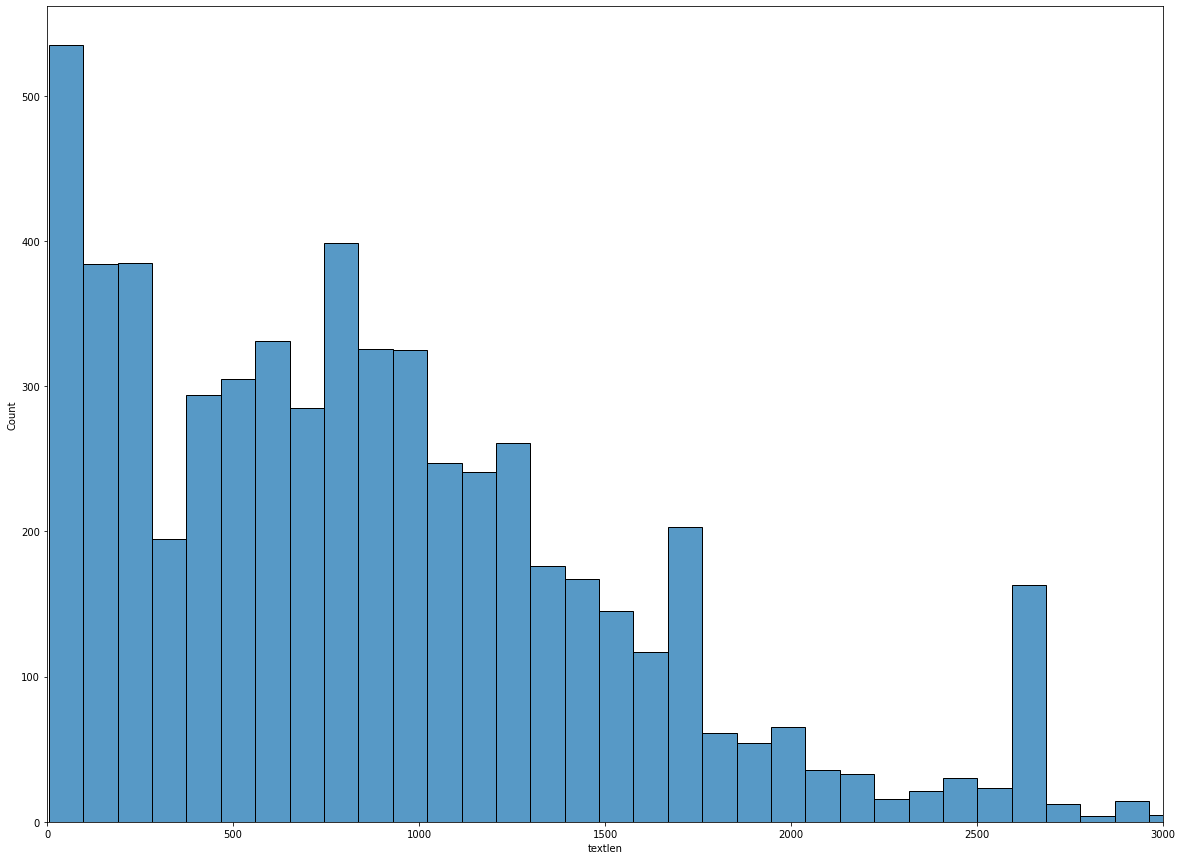

In [44]:
plt.figure(figsize=(20, 15))
sns.histplot(data=_data, x="textlen", bins=100).set(xlim=(0, 3000))

## MultiLabelEncoder Analysis

Since, the problem is a multi-label clasification (if we treat the problem as a classification problem), we need to see if we can encode the labels accordingly!

In [45]:
from sklearn.preprocessing import MultiLabelBinarizer

In [46]:
DATA_TO_USE = DATA.copy()
DATA_TO_USE = DATA_TO_USE[DATA_TO_USE["textlen"]<=500]
DATA_TO_USE.shape

(1930, 4)

In [47]:
DATA_TO_USE.head()

,desc,keywords,labels,textlen
0,USGS 15 minute stream flow data for Kings Cree...,EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURF...,[terrestrial hydrosphere],68
1,"This data set contains the VSMOW-SLAP d17O, d1...",EARTH SCIENCE > Solid Earth > Rocks/Minerals >...,"[cryosphere, solid earth]",425
12,30 minute rainfall data for the Konza Prairie,EARTH SCIENCE > ATMOSPHERE > PRECIPITATION > P...,[atmosphere],45
21,This data set provides glacier surface ablatio...,EARTH SCIENCE > Cryosphere > Glaciers/Ice Shee...,"[cryosphere, terrestrial hydrosphere]",367
22,This data set provides a fire progression map ...,EARTH SCIENCE > BIOSPHERE > ECOLOGICAL DYNAMIC...,"[land surface, biosphere]",415


In [49]:
# Note: Now our level 1 keywords are <29 (N=22) classes because we have filtered the data 
analyze_labels(DATA_TO_USE)

2021-07-28 19:13:36.353 | INFO     | __main__:analyze_labels:5 - 22 unique labels


In [50]:
LE = MultiLabelBinarizer()
LABELS_ENCODED = LE.fit_transform(DATA_TO_USE["labels"])

In [59]:
# 22 classes for level=1 keywords
LABELS_ENCODED.shape

(1930, 22)

In [60]:
LABELS_ENCODED[:10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [61]:
LE.classes_

array(['active remote sensing', 'agriculture', 'atmosphere',
       'biological classification', 'biosphere', 'climate indicators',
       'cryosphere', 'data analysis and visualization',
       'environmental advisories', 'human dimensions', 'hydrosphere',
       'land surface', 'nasa decadal survey', 'none', 'not provided',
       'oceans', 'paleoclimate', 'solid earth', 'spectral engineering',
       'spectral/engineering', 'sun-earth interactions',
       'terrestrial hydrosphere'], dtype=object)

In [62]:
# Test if inverse works
# Note: encoded lables should be 1s and 0s
LE.inverse_transform(LABELS_ENCODED[:10])

[('terrestrial hydrosphere',),
 ('cryosphere', 'solid earth'),
 ('atmosphere',),
 ('cryosphere', 'terrestrial hydrosphere'),
 ('biosphere', 'land surface'),
 ('biosphere', 'human dimensions'),
 ('atmosphere', 'biosphere', 'human dimensions', 'land surface'),
 ('atmosphere', 'sun-earth interactions'),
 ('atmosphere', 'sun-earth interactions'),
 ('cryosphere', 'land surface')]

In [64]:
DATA_TO_USE["labels_encoded"] = list(LABELS_ENCODED)

In [66]:
DATA_TO_USE.head()

,desc,keywords,labels,textlen,labels_encoded
0,USGS 15 minute stream flow data for Kings Cree...,EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURF...,[terrestrial hydrosphere],68,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"This data set contains the VSMOW-SLAP d17O, d1...",EARTH SCIENCE > Solid Earth > Rocks/Minerals >...,"[cryosphere, solid earth]",425,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
12,30 minute rainfall data for the Konza Prairie,EARTH SCIENCE > ATMOSPHERE > PRECIPITATION > P...,[atmosphere],45,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
21,This data set provides glacier surface ablatio...,EARTH SCIENCE > Cryosphere > Glaciers/Ice Shee...,"[cryosphere, terrestrial hydrosphere]",367,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
22,This data set provides a fire progression map ...,EARTH SCIENCE > BIOSPHERE > ECOLOGICAL DYNAMIC...,"[land surface, biosphere]",415,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
